In [1]:
import scipy.signal as ss 
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
from PyAstronomy.pyasl import foldAt
from PyAstronomy.pyTiming import pyPDM
import matplotlib.pylab as plt
from scipy import interpolate
import os,pickle,time
from tensorflow.keras.models import load_model
import pandas as pd
import emcee
import corner
import phoebe
import os
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
def calculater(ydata, caldata):
    res_ydata  = np.array(ydata) - np.array(caldata)
    stdres = np.std(res_ydata)
    ss_res     = np.sum(res_ydata**2)
    ss_tot     = np.sum((ydata - np.mean(ydata))**2)
    r_squared  = 1 - (ss_res / ss_tot)
    return stdres,r_squared

In [3]:
def quantile(x, q, weights=None): 
 
    x = np.atleast_1d(x)
    q = np.atleast_1d(q)

    if np.any(q < 0.0) or np.any(q > 1.0):
        raise ValueError("Quantiles must be between 0 and 1")

    if weights is None:
        return np.percentile(x, list(100.0 * q))
    else:
        weights = np.atleast_1d(weights)
        if len(x) != len(weights):
            raise ValueError("Dimension mismatch: len(weights) != len(x)")
        idx = np.argsort(x)
        sw = weights[idx]
        cdf = np.cumsum(sw)[:-1]
        cdf /= cdf[-1]
        cdf = np.append(0, cdf)
        return np.interp(q, cdf, x[idx]).tolist()

In [4]:
def plotphoebenol3T(padata, times):
    #logger = phoebe.logger('warning')
    incl = padata[1]*90
    q = padata[2]
    f = padata[3]
    t2t1 = padata[4]
    b = phoebe.default_binary(contact_binary=True)
    times = times
    b.add_dataset('lc', times=times, passband= 'Kepler:mean')
    
    b['period@binary'] = 1

    b['incl@binary'] = incl #58.528934
    b['q@binary'] =   q
    b['teff@primary'] = padata[0]*5850#6500#6500  #6208 
    b['teff@secondary'] = padata[0]*5850*t2t1#6500*92.307556*0.01#6500*100.08882*0.01 #6087

    b['sma@binary'] = 1#0.05 2.32
    
    b.flip_constraint('pot', solve_for='requiv@primary')
    b.flip_constraint('fillout_factor', solve_for='pot')
    b['fillout_factor'] = f    #0.61845703
    
    try:
        try:
            b.run_compute(irrad_method='none')
        except:
            b.run_compute(ntriangles = 8000)
            
        try:
            lumidata = b.compute_pblums()
            pbdic = np.float64(lumidata['pblum@secondary@lc01']/lumidata['pblum@primary@lc01'])
        except:
            pbdic = 0
            
        print('it is ok')
        
        pr1 = b['value@requiv@primary@component']
        pr2 = b['value@requiv@secondary@component']
        
        fluxmodel = b['value@fluxes@lc01@model']
        resultflux = -2.5*np.log10(fluxmodel)
        resultflux = resultflux - np.mean(resultflux)
        return times,resultflux, pbdic, pr1, pr2
        #return times,resultflux, 0, 0, 0
    except:
        return times, times, 0, 0, 0     

In [5]:
def plotphoebel3T(padata,times):
    #logger = phoebe.logger('warning')  
    incl = padata[1]*90
    q = padata[2]
    f = padata[3]
    t2t1 = padata[4]
    l3fra = padata[5]
    
    b = phoebe.default_binary(contact_binary=True)
    times = times
    b.add_dataset('lc', times=times, passband= 'Kepler:mean')
    b.set_value('l3_mode', 'fraction')
    b['period@binary'] = 1

    b['incl@binary'] = incl #58.528934
    b['q@binary'] =   q
    b['teff@primary'] = padata[0]*5850#6500#6500  #6208 
    b['teff@secondary'] = padata[0]*5850*t2t1#6500*92.307556*0.01#6500*100.08882*0.01 #6087
    b.set_value('l3_frac', l3fra)
    b['sma@binary'] = 1#0.05 2.32
    
    b.flip_constraint('pot', solve_for='requiv@primary')
    b.flip_constraint('fillout_factor', solve_for='pot')
    b['fillout_factor'] = f    #0.61845703
    
    try:
        try:
            b.run_compute(irrad_method='none')
        except:
            b.run_compute(ntriangles = 8000)
            
        try:
            lumidata = b.compute_pblums()
            pbdic = np.float64(lumidata['pblum@secondary@lc01']/lumidata['pblum@primary@lc01'])
        except:
            pbdic = 0
            
        print('it is ok')
        pr1 = b['value@requiv@primary@component']
        pr2 = b['value@requiv@secondary@component']

        fluxmodel = b['value@fluxes@lc01@model']
        resultflux = -2.5*np.log10(fluxmodel)
        resultflux = resultflux - np.mean(resultflux)
        return times,resultflux, pbdic, pr1, pr2
    except:
        return times,times, 0, 0, 0

In [6]:
mpath = ''
model10mc = load_model(mpath+'model10mc.hdf5')
l3model10mc = load_model(mpath+'model10l3mc.hdf5')
path = '/home/dingxu/桌面/papercode/kepler/Kepler/KIC_name/'
fileone = 'KIC 4941060.txt'
data = np.loadtxt(path+fileone)
phrase = data[:,0]
datay = data[:,1]-np.mean(data[:,1])
x = np.linspace(0,1,100) #x轴
sigma = np.diff(datay, 2).std()/np.sqrt(6) #估计观测噪声值
#sigma=1

2022-06-10 15:41:28.216866: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-10 15:41:28.216908: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: dingxu-OptiPlex-7060
2022-06-10 15:41:28.216914: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: dingxu-OptiPlex-7060
2022-06-10 15:41:28.217045: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-06-10 15:41:28.217063: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-06-10 15:41:28.217068: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-06-10 15:41:28.217272: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the follow

In [7]:
###########MCMC参数
nwalkers = 60
niter = 1000
nburn=200 #保留最后多少点用于计算
index = 0

##初始范围[T/5850，incl/90,q,f,t2t1,l3,offset1, offset2]
init_dist = [(0.88-0.0001, 0.88+0.0001), 
             (0.6, 0.84), 
             (3, 5), 
             (0, 0.2), 
             (0.9, 1.1),
             #(0,1),
             (-10,10),
             (-0.01,0.01)
             ]

priors=init_dist.copy()
ndim = len(priors) #维度数

In [8]:
def predict(allpara):
    
    arraymcn = np.array(allpara)
    
    if index == 0:
        arraymc = arraymcn[0:5]
        mcinput = np.reshape(arraymc,(1,5))
        lightdata = model10mc(mcinput)
        return lightdata[0]+arraymcn[6]
        
        
    if index == 1:
        arraymc = arraymcn[0:6]
        mcinput = np.reshape(arraymc,(1,6))
        lightdata = l3model10mc(mcinput)
        return lightdata[0]+arraymcn[7]

In [9]:
def getdata(allpara):
    arraymc = np.array(allpara)
    if index == 0:
        offset = int(arraymc[5])
        dataym = np.hstack((datay[offset:], datay[:offset]))
        
    if index == 1:
        offset = int(arraymc[6])
        dataym = np.hstack((datay[offset:], datay[:offset]))
    
    noisy = np.interp(x,phrase,dataym) #y轴
    
    return noisy

In [10]:
def rpars(init_dist):#在ndim 维度上，在初始的范围里面均匀撒ndim个点
    return [np.random.rand() * (i[1]-i[0]) + i[0] for i in init_dist] 


def lnprior(priors, values):#判断MCMC新的点是否在初始的区域里面
    
    lp = 0.
    for value, prior in zip(values, priors):
        if value >= prior[0] and value <= prior[1]:
            lp+=0
        else:
            lp+=-np.inf 
    return lp


def lnprob(z): #计算后仰概率
    
    lnp = lnprior(priors,z)#判断MCMC新的点是否在初始的区域里面

    if not np.isfinite(lnp):
            return -np.inf


    output = predict(z)
    
    noisy = getdata(z)
    
    lnp = -0.5*np.sum(np.log(2 * np.pi * sigma ** 2)+(output-noisy)**2/(sigma**2)) #计算似然函数
      
    return lnp

In [11]:
# def run(init_dist, nwalkers, niter,nburn):
    
#     ndim = len(init_dist)
#     # Generate initial guesses for all parameters for all chains
#     p0 = [rpars(init_dist) for i in range(nwalkers)] #均匀撒ndim*nwalkers点

#     sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob) #建立MCMC模型
#     pos, prob, state = sampler.run_mcmc(p0, niter, progress=True) # 撒点
#     emcee_trace = sampler.chain[:, -nburn:, :].reshape(-1, ndim).T #保留最后nburn 个点做统计

#     return emcee_trace

In [12]:
from multiprocessing import Pool
def run(init_dist, nwalkers, niter,nburn):
    ndim = len(init_dist)
    p0 = [rpars(init_dist) for i in range(nwalkers)] #均匀撒ndim*nwalkers点
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
        sampler.run_mcmc(p0, niter, progress=True)
        pos, prob, state = sampler.run_mcmc(p0, niter, progress=True) # 撒点
        emcee_trace = sampler.chain[:, -nburn:, :].reshape(-1, ndim).T #保留最后nb
    return emcee_trace

In [13]:
t1=time.time()  
emcee_trace  = run(priors, nwalkers, niter, nburn) #run mcmc
print('time=',time.time()-t1) #MCMC运行时间

100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.64it/s]


time= 42.40537643432617


In [14]:
mu = []
sigma_1 = []
sigma_2 = []
    
for mi, x1 in enumerate(emcee_trace):
    q_16, q_50, q_84 = quantile(x1, [0.16, 0.5, 0.84])          
    q_m, q_p = q_50 - q_16, q_84 - q_50
  
    mu.append(q_50) #median value
    sigma_1.append(q_m) #high limitation
    sigma_2.append(q_p) #low
 
sigma_1 = np.array(sigma_1)
sigma_2 = np.array(sigma_2) 

In [15]:
if index == 0:
    times,resultflux, pbdic, pr1, pr2 = plotphoebenol3T(mu, x)
else:
    t1=time.time()
    times,resultflux, pbdic, pr1, pr2 = plotphoebel3T(mu,x)
    print('time=',time.time()-t1) #MCMC运行时间
    
print('r1 = ', pr1)
print('r2 = ', pr2)
print('pbdic = ', pbdic)

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 28.34it/s]


it is ok
r1 =  0.27901330358614007
r2 =  0.5074560997868054
pbdic =  2.126788437761059


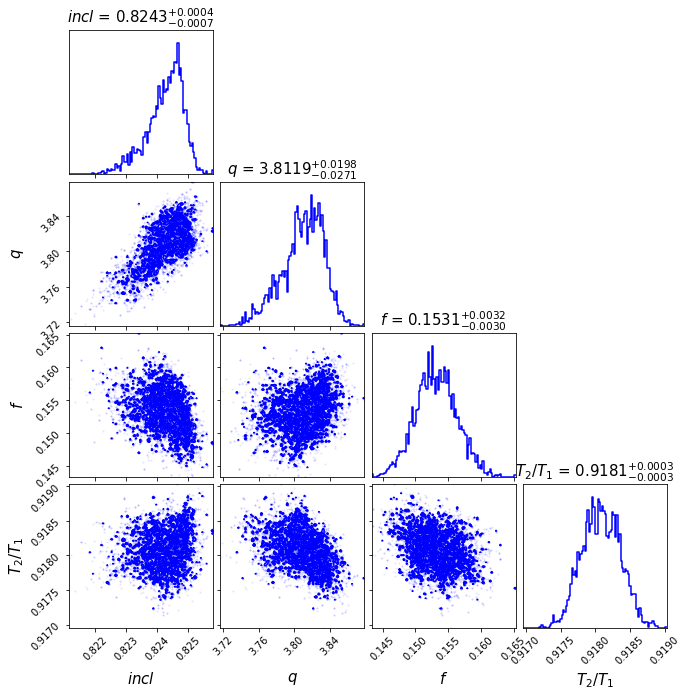

In [16]:

if index == 1:
    figure = corner.corner(emcee_trace.T[:,1:6],bins=100,
                           labels=[r"$incl$", r"$q$", r"$f$", r"$T_2/T_1$", r"$l3$", r"$offset1$", r"$offset2$"],
                           label_kwargs={"fontsize": 15},title_fmt='.3f',show_titles=True, title_kwargs={"fontsize": 15}, color ='blue',
                           fill_contours=True,smooth=0.3,smooth1d=0.3)

if index == 0:
    figure = corner.corner(emcee_trace.T[:,1:5],bins=100,
                           labels=[r"$incl$", r"$q$", r"$f$", r"$T_2/T_1$", r"$offset1$", r"$offset2$"],
                           label_kwargs={"fontsize": 15},title_fmt='.4f',show_titles=True, title_kwargs={"fontsize": 15}, color ='blue',
                           fill_contours=True,smooth=0.3,smooth1d=0.3)
    
plt.savefig('corner.png')

R_2 =  0.9977999777091099
T1 = 5148.183380912993
incl = 74.19140025208816
q = 3.8119074839047373
f = 0.15312730590804502
t2t1 = 0.918081480524084


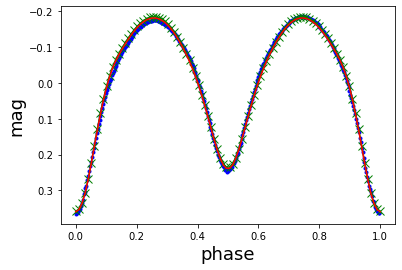

In [17]:
pre = predict(mu)
plt.figure()
ax = plt.gca()

if index == 0:
    offset = int(mu[5])
else :
    offset = int(mu[6])

datay = np.hstack((datay[offset:], datay[:offset])) 
noisy = np.interp(x, phrase, datay)  
stdres,r_squared = calculater(noisy, resultflux)
print('R_2 = ', r_squared)
 
ax.plot(phrase, datay, '.', c = 'b')
ax.plot(times, resultflux, marker='x', c='g', markersize = 8) #理论数据
ax.plot(x, pre,'-r') #理论数据
ax.yaxis.set_ticks_position('left') #将y轴的位置设置在右边
ax.invert_yaxis() #y轴反向
plt.xlabel('phase',fontsize=18)
plt.ylabel('mag',fontsize=18)

print('T1 = '+str(mu[0]*5850))
print('incl = '+str(mu[1]*90))
print('q = '+str(mu[2]))
print('f = '+str(mu[3]))
print('t2t1 = '+str(mu[4]))

if index == 1:
    print('l3 = '+str(mu[5]))